In [183]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

case_to_evaluate="9_3_2"

# Load data


In [184]:
combined_imputed_cells = pd.read_csv(f"data/{case_to_evaluate}/distance_based/combined_imputed_cells.csv")
combined_replaced_cells = pd.read_csv(f"data/{case_to_evaluate}/distance_based/combined_replaced_cells.csv")
combined_test_cells = pd.read_csv(f"data/{case_to_evaluate}/distance_based/combined_test_cells.csv")

# Examine data

## Check replaced data

Mean intensities with 0s refer to cells without neighbors

In [170]:
combined_replaced_cells.head()

,Mean Neighbor Intensity pERK,Mean Neighbor Intensity Rad51,Mean Neighbor Intensity CCND1,Mean Neighbor Intensity Vimentin,Mean Neighbor Intensity aSMA,Mean Neighbor Intensity Ecad,Mean Neighbor Intensity ER,Mean Neighbor Intensity PR,Mean Neighbor Intensity EGFR,Mean Neighbor Intensity pRB,...,Eccentricity,X_centroid,Y_centroid,Phenotype,# of Immune Cells,# of Neoplastic Epithelial Cells,# of Stroma Cells,Cell Neighborhood,Cell Neighborhood Encoded,Radius
0,-1.982650,-2.573164,-2.214435,-0.907921,-1.803212,-1.541311,-2.458003,-1.415121,-1.582431,-1.283895,...,0.263662,5040.107143,380.589286,Stroma (aSMA+),1,0,0,Immune,1,30
1,-2.053947,-2.408625,-2.256200,-0.959125,1.026614,-1.297823,-2.112923,-1.012705,-0.904860,-0.819339,...,-0.088532,5039.914286,390.609524,Immune,0,0,1,Stroma (aSMA+),4,30
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,9388.723301,1230.747573,Basal,0,0,0,Unknown,5,30
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.826378,4977.342105,1463.052632,Immune,0,0,0,Unknown,5,30
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.058586,3591.947368,1820.506579,Immune,0,0,0,Unknown,5,30


In [171]:
combined_replaced_cells["# of Neighbors"] = combined_replaced_cells["# of Immune Cells"] + combined_replaced_cells["# of Neoplastic Epithelial Cells"] + combined_replaced_cells["# of Stroma Cells"]
combined_replaced_cells["# of Neighbors"].value_counts()

5      3134
6      3056
7      2977
4      2801
8      2708
       ... 
171       3
181       3
184       3
186       2
187       1
Name: # of Neighbors, Length: 188, dtype: int64

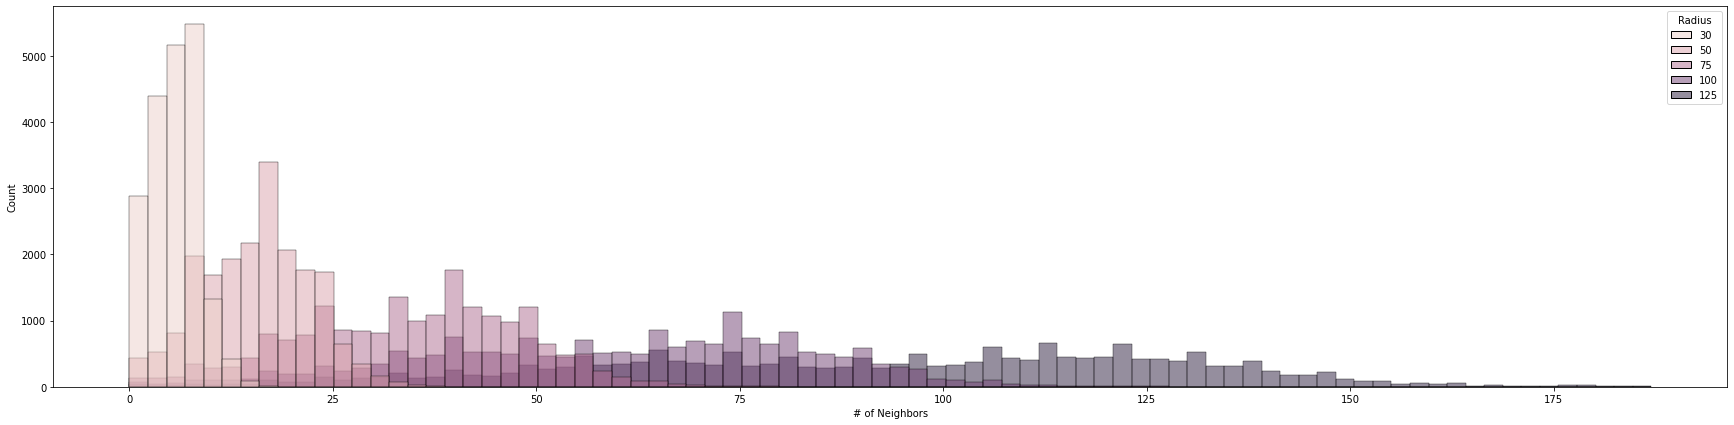

In [172]:
fig = plt.figure()
ax = sns.histplot(data=combined_replaced_cells, x="# of Neighbors", hue="Radius")
#plt.xticks(combined_replaced_cells["# of Neighbors"].unique())
fig.set_size_inches(30,7)
plt.show()

## Count NAs per row

20% replaced data should yield a mean of 5 replaced features

In [173]:
combined_replaced_cells.isna().sum(axis=1).mean()

5.0

## Test Data

In [174]:
# Available Distances

combined_test_cells["Radius"].unique()

array([ 30,  50,  75, 100, 125])

# Index Replacments

In [175]:
index_replacements = pd.read_csv("data/distance_based/index_replacements.csv")
print(index_replacements)
index_replacements = index_replacements.T.to_dict()

                     0             1                2         3         4
0                 CK14          CK19             CK17        ER      Ki67
1             Vimentin          CK19           Extent     Rad51        PR
2                  p21  Eccentricity  MinorAxisLength      HER2      aSMA
3                 pERK          Ki67           Extent      aSMA       pRB
4                 Ki67        Extent             CK14       p21        ER
...                ...           ...              ...       ...       ...
19734         Vimentin          CK14             CK19      Area      HER2
19735            cPARP          aSMA              p21     Rad51  Solidity
19736  MajorAxisLength           CK7             CK14  Solidity     CCND1
19737            Rad51           pRB             CK14      EGFR        PR
19738         Solidity          Ki67             EGFR      Ecad      pERK

[19739 rows x 5 columns]


# Load imputed features

In [176]:
features = pd.read_csv("data/distance_based/features_to_impute.csv")
features = features["0"].to_list()
features

['pERK',
 'Rad51',
 'CCND1',
 'Vimentin',
 'aSMA',
 'Ecad',
 'ER',
 'PR',
 'EGFR',
 'pRB',
 'CD45',
 'Ki67',
 'CK19',
 'p21',
 'CK14',
 'AR',
 'cPARP',
 'CK17',
 'CK7',
 'HER2',
 'Area',
 'MajorAxisLength',
 'MinorAxisLength',
 'Solidity',
 'Extent',
 'Eccentricity',
 'X_centroid',
 'Y_centroid']

# R2 score calculation

In [177]:
from typing import List, Dict
from sklearn.metrics import r2_score

def evaluate_performance(features: List, index_replacements: Dict, test_data: pd.DataFrame,
                             imputed_data: pd.DataFrame):
        """
        Evaluates the performance per feature
        @param features:
        @param index_replacements:
        @param test_data:
        @param imputed_data:
        @return: Returns a dataframe with r2 scores for performance evaluation
        """
        score_data: List = []

        for feature in features:
            if "X_centroid" in feature or "Y_centroid" in feature or "Origin" in feature:
                continue

            # Store all cell indexes, to be able to select the correct cells later for r2 comparison
            cell_indexes_to_compare: list = []
            for key, replaced_features in index_replacements.items():
                key = int(key)
                replaced_features = list(replaced_features.values())
                
                if feature in replaced_features:
                    cell_indexes_to_compare.append(key)
           
            score = r2_score(test_data[feature].loc[cell_indexes_to_compare],
                                  imputed_data[feature].loc[cell_indexes_to_compare])
                    
            score_data.append({
                "Feature": feature,
                "Score": score if score >= 0 else 0
            })

        return pd.DataFrame().from_records(score_data)

In [178]:
distance  = 300

selected_test_cells = combined_test_cells[combined_test_cells["Radius"] == distance].reset_index(drop=True)
selected_imputed_cells = combined_imputed_cells[combined_imputed_cells["Radius"] == distance].reset_index(drop=True)

#selected_imputed_cells.filter(regex=("Mean *"))
selected_imputed_cells.filter(features)
#selected_test_cells.filter(features)


,pERK,Rad51,CCND1,Vimentin,aSMA,Ecad,ER,PR,EGFR,pRB,...,cPARP,CK17,CK7,HER2,Area,MajorAxisLength,MinorAxisLength,Solidity,Extent,Eccentricity


In [182]:
combined_r2_scores_data = []
for radius in combined_test_cells["Radius"].unique():
    selected_test_cells = combined_test_cells[combined_test_cells["Radius"] == radius].reset_index(drop=True)
    selected_imputed_cells = combined_imputed_cells[combined_imputed_cells["Radius"] == radius].reset_index(drop=True)
    
    r2_scores = evaluate_performance(features, index_replacements, selected_test_cells, selected_imputed_cells)
    r2_scores["Radius"] = radius
    combined_r2_scores_data.append(r2_scores)
    
combined_r2_scores = pd.concat(combined_r2_scores_data)
combined_r2_scores.to_csv("data/distance_based/combined_r2_scores.csv", index=False)
combined_r2_scores

,Feature,Score,Radius
0,pERK,0.296878,30
1,Rad51,0.196661,30
2,CCND1,0.341591,30
3,Vimentin,0.134690,30
4,aSMA,0.206042,30
...,...,...,...
21,MajorAxisLength,0.102092,125
22,MinorAxisLength,0.163441,125
23,Solidity,0.000000,125
24,Extent,0.000000,125


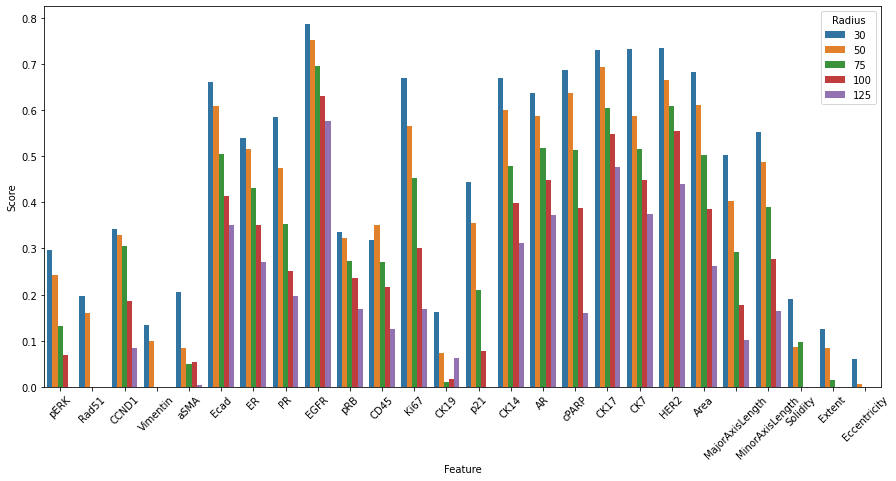

In [180]:
fig = plt.figure()
sns.barplot(x="Feature", y="Score",hue="Radius", data=combined_r2_scores)
for ax in fig.axes:
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
fig.set_size_inches(15,7)
plt.show()